In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from utils.portfolio_backtests import *
from utils.trading_model import *
from utils.experiment_utils import *
from utils.portfolio_backtests import MeanVariance

from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

import datetime
import random

sns.set()
sns.set(font_scale=1.5)

boolUniformlyDistributedDataset = True
percentageOfRemovedDays = 40

In [2]:
def plot_prices_volatilities_for_rw(stock_prices, real_volatility, rw_volatility, asset_name):
    '''
    Function to plot prices and volatilities for rolling window
    '''
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 11), sharex=True)

    # Plot stock prices
    ax1.plot(stock_prices[asset_name], label=f'{asset_name} Price', color='green')
    ax1.set_title(f'{asset_name} Stock Prices')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    
    # Plot real and rolling window volatilities
    ax2.plot(real_volatility, label=f'Real {asset_name} Volatility', color='blue')
    ax2.plot(rw_volatility, label=f'RW {asset_name} Volatility', color='orange', linestyle='--')
    ax2.set_title(f'{asset_name} Volatility: Real vs Rolling Window')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volatility')
    ax2.legend(loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


def plot_prices_volatilities_for_ewma(stock_prices, real_volatility, ewma_volatility, asset_name):
    '''
    Function to plot prices and volatilities for EWMA
    '''
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 11), sharex=True)

    # Plot stock prices
    ax1.plot(stock_prices[asset_name], label=f'{asset_name} Price', color='green')
    ax1.set_title(f'{asset_name} Stock Prices')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    
    # Plot real and rolling window volatilities
    ax2.plot(real_volatility, label=f'Real {asset_name} Volatility', color='blue')
    ax2.plot(ewma_volatility, label=f'EWMA {asset_name} Volatility', color='orange', linestyle='--')
    ax2.set_title(f'{asset_name} Volatility: Real vs EWMA')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volatility')
    ax2.legend(loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Import data

In [3]:
stocksPrices = pd.read_csv('data/stocksPrices.csv', index_col=0, parse_dates=True)
stocksPercentageChangeReturn = pd.read_csv('data/stocksPercentageChange.csv', index_col=0, parse_dates=True)
uniformlyDistributedReturns = stocksPercentageChangeReturn.copy() # this is a copy of the original dataset returns; i will use this to make it non-uniformly distributed

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# i have 13 years of trading data; 3273 days; now i will split the dataset into 70% training, 20% validation and 10% test

total_days = len(stocksPrices)
date_70_percent = stocksPrices.index[int(total_days * 0.7)]
date_90_percent = stocksPrices.index[int(total_days * 0.9)]

# 70% training
trainingData = stocksPrices.loc[:date_70_percent]

# 20% validation
validationData = stocksPrices.loc[date_70_percent:date_90_percent]

# 10% test
testData = stocksPrices.loc[date_90_percent:]

In [4]:
print("original returns dataframe dimension: " + str(stocksPercentageChangeReturn.shape))

# Import pickle
with open('data/permco_to_ticker.pkl', 'rb') as f:
    permco_to_ticker = pickle.load(f)

# Create a reverse mapping if necessary
ticker_to_permco = {v: k for k, v in permco_to_ticker.items()}

# Replace ticker symbols with PERMCO codes if the ticker symbol is found in the reverse mapping
columns = [ticker_to_permco.get(col, col) for col in stocksPercentageChangeReturn.columns]
stocksPercentageChangeReturn.columns = columns

# Repeat for uniformlyDistributedReturns
columns_udr = [ticker_to_permco.get(col, col) for col in uniformlyDistributedReturns.columns]
uniformlyDistributedReturns.columns = columns_udr

original returns dataframe dimension: (3272, 3)


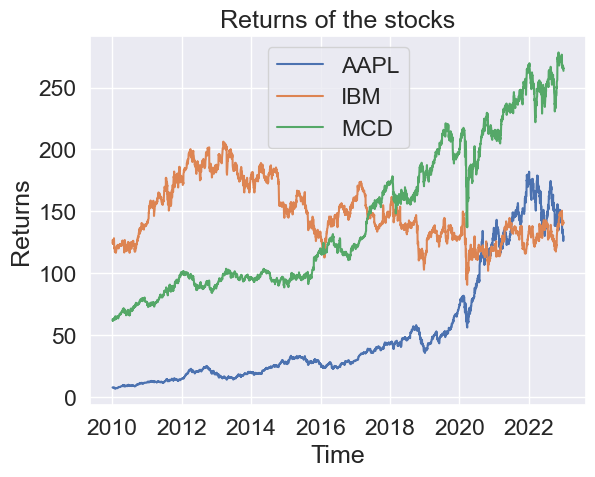

In [5]:
# plot the returns of the stocks
plt.plot(stocksPrices)

# write a legend: the green line is aapl; the blue line is ibm; the red line is mcd(this is just an example)
plt.legend(["AAPL", "IBM", "MCD"])
plt.title("Returns of the stocks")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.show()


# Dictionary Initialisation

In [6]:
prescientDict = {}
log_likelihoods = {}
regrets = {}

# create a dictionary for every predictor that saves the log-likelihoods and the regrets
log_likelihood_rw = {}
log_likelihood_ewma = {}
log_likelihood_mgarch = {}
log_likelihood_prescient = {}

regret_rw = {}
regret_ewma = {}
regret_mgarch = {}
regret_prescient = {}

# Covariance predictors

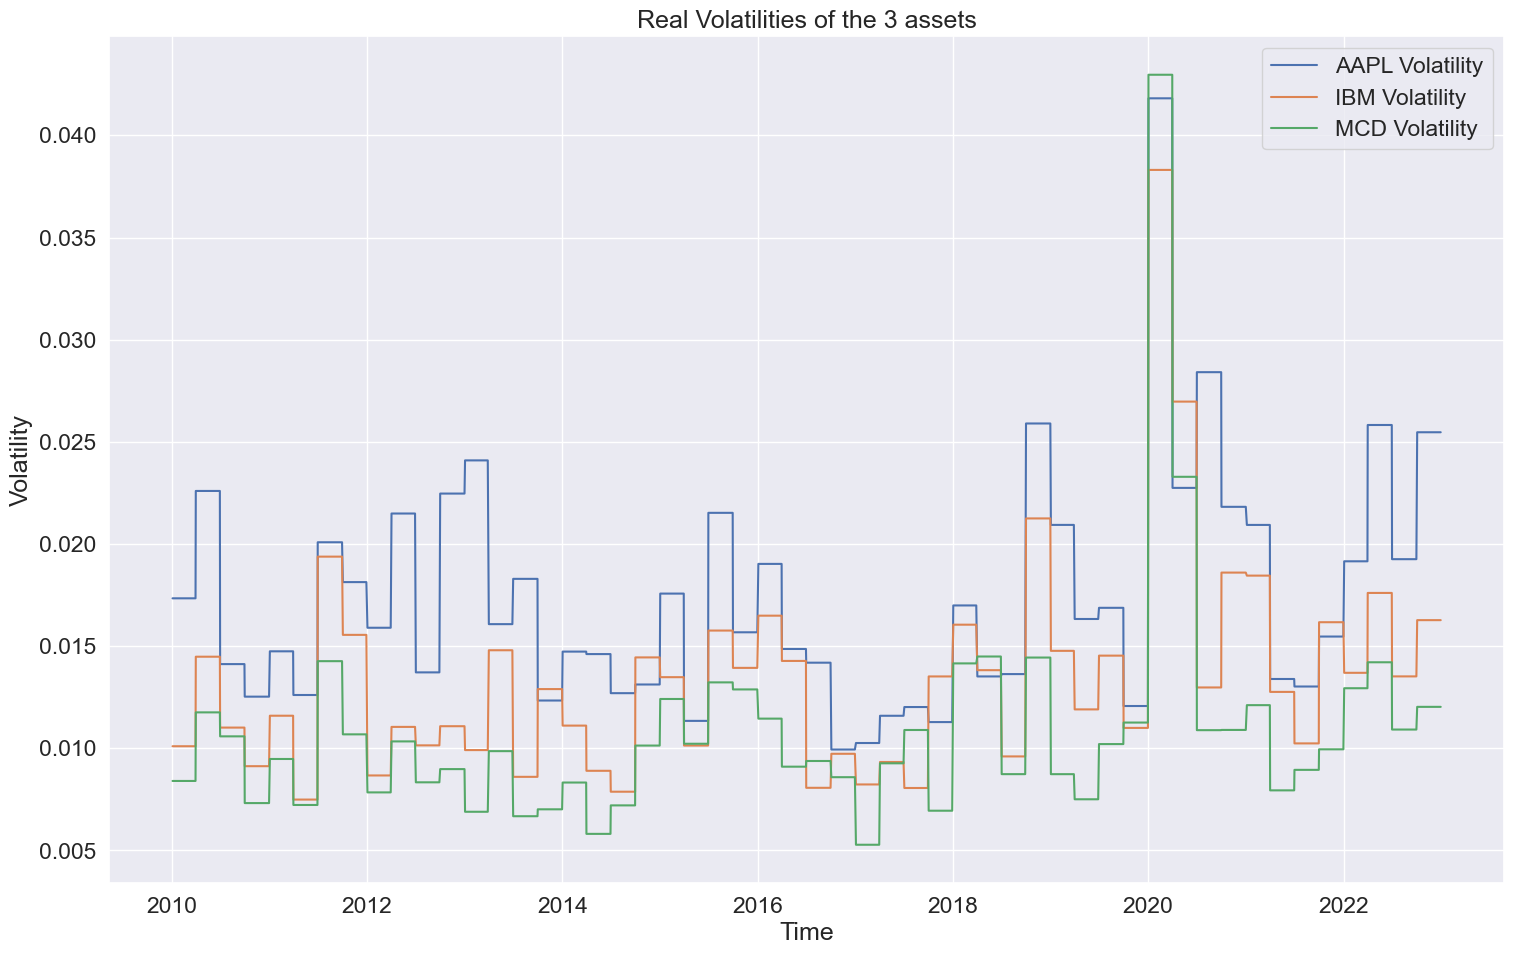

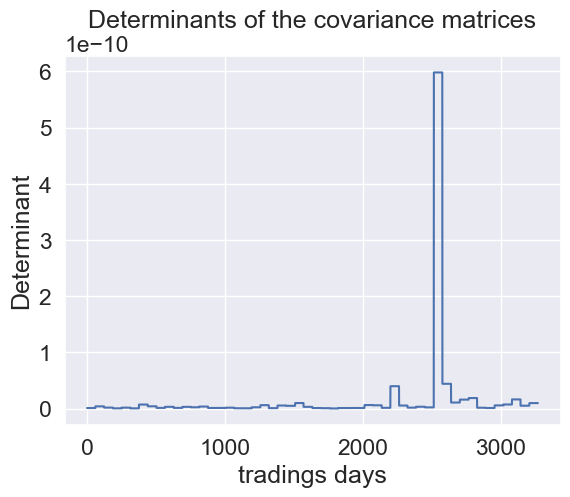

In [7]:
# PRESCIENT 

# prescient is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day

# The prescient predictor will always use the original dataset, so it will be uniformly distributed; this is because the prescient predictor is used to compare the other predictors
# and we need to have a measure of the real covariance matrix; so this can't be used with the non-uniformly distributed dataset

for t in uniformlyDistributedReturns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(uniformlyDistributedReturns.loc[(uniformlyDistributedReturns.index.year == t.year) & (uniformlyDistributedReturns.index.quarter == quarter)].values, axis=0)
    prescientDict[t] = pd.DataFrame(cov+np.outer(mean, mean), index=uniformlyDistributedReturns.columns, columns=uniformlyDistributedReturns.columns)


# now calculates/extract the real volatilities of the 3 assets
real_volatilities = {}

for date, cov_matrix in prescientDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    real_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now real_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the prescientDict dictionary(the timestamp)

# now separate the real volatilities of the 3 assets in 3 different dataframes
volatility_dict_aapl = {}
volatility_dict_ibm = {}
volatility_dict_mcd = {}

for date, volatilities in real_volatilities.items():
    volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_volatility_aapl = pd.DataFrame(list(volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_volatility_ibm = pd.DataFrame(list(volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_volatility_mcd = pd.DataFrame(list(volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_volatility_aapl.set_index('Date', inplace=True)
df_volatility_ibm.set_index('Date', inplace=True)
df_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_volatility_aapl, label='AAPL Volatility')
plt.plot(df_volatility_ibm, label='IBM Volatility')
plt.plot(df_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Real Volatilities of the 3 assets")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()

# now let's study why the prescient predictor has a positive log-likelihood and a 0 regret: i make a list off all the determinants of the covariance matrices and i plot them
determinants = []
for date, cov_matrix in prescientDict.items():
    determinants.append(np.linalg.det(cov_matrix))

# in particular i want to se if it is greater than 1 or not
plt.plot(determinants)
plt.title("Determinants of the covariance matrices")
plt.xlabel("tradings days")
plt.ylabel("Determinant")
plt.show()

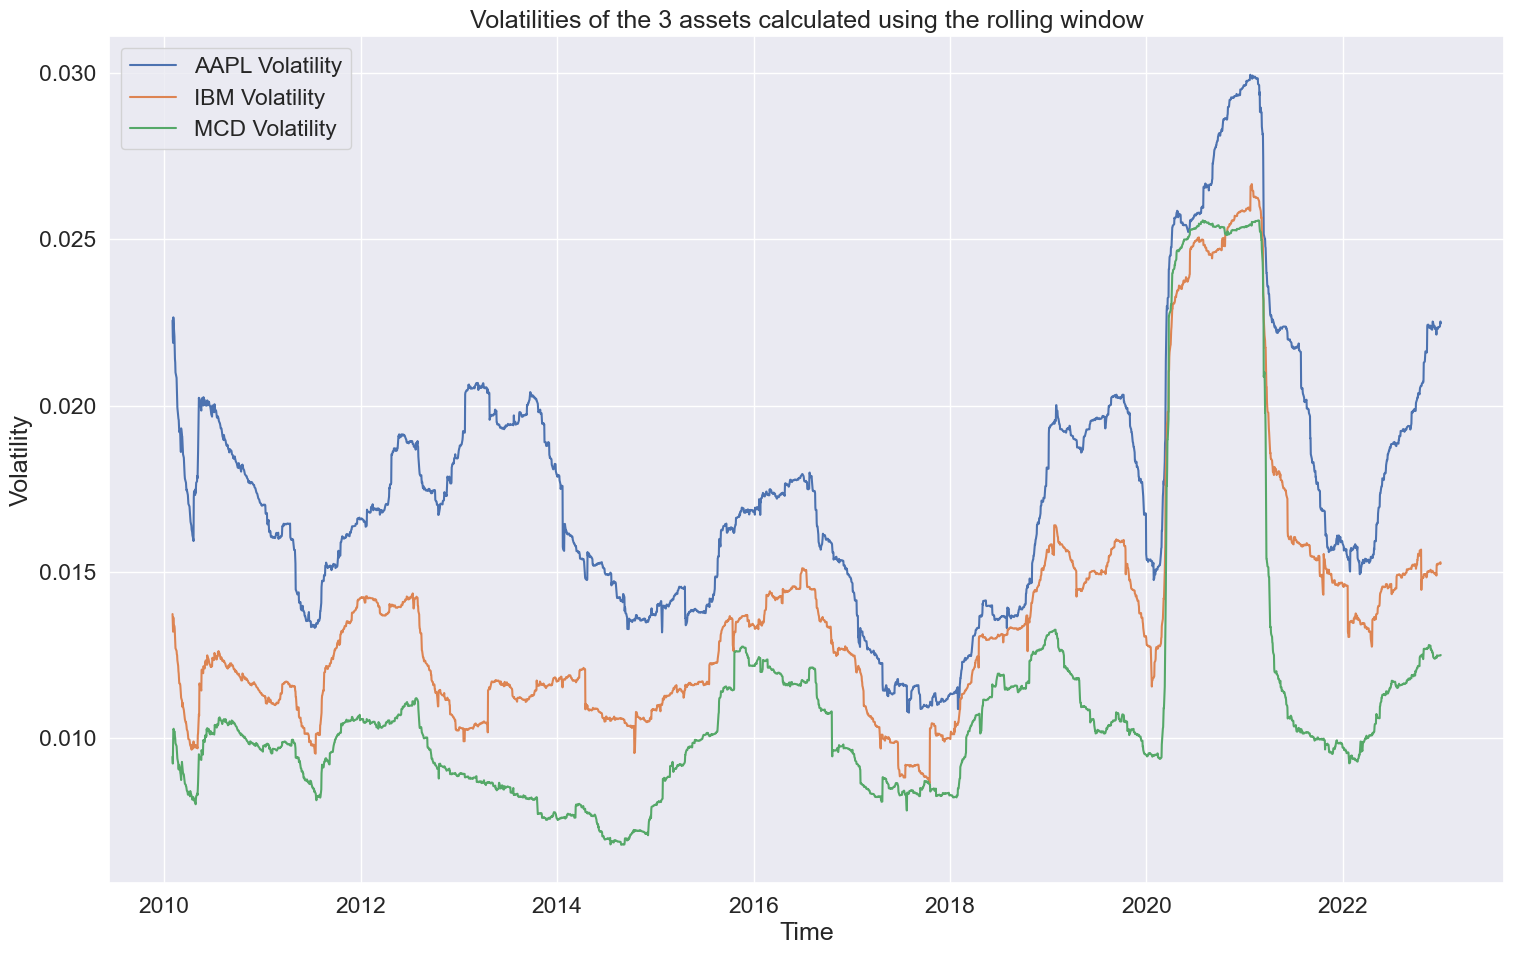

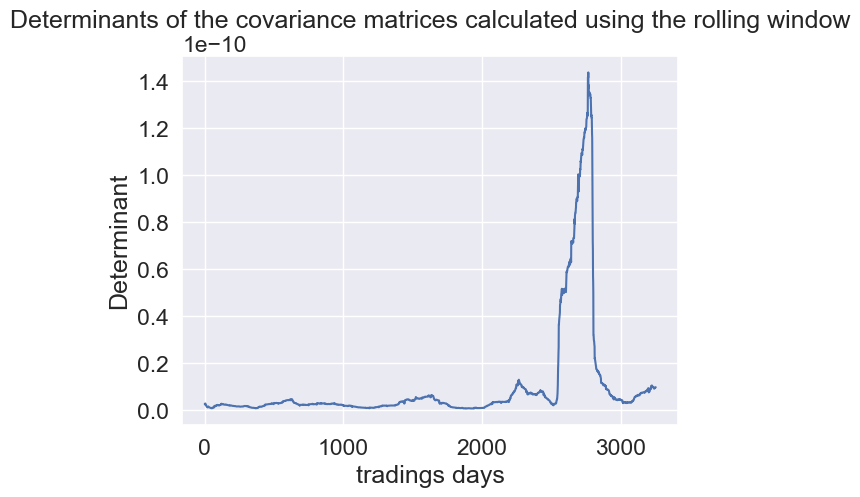

In [8]:
# Rolling window 

rw_memory = 250

# returns a dictionary where each key is a time period, and the corresponding value is the DataFrame representing the covariance matrix for that period.
# It only includes the periods after the min_periods threshold is met, ensuring that there's sufficient data to provide meaningful covariance estimates.

# Furthermore: inside the rolling window function there is the implementation of formula to calculate the covariance matrix written inside the paper;
# So the covariance matrix calculated at time t(i know the time from the key of the dictionary) is calculated using the formula written inside the paper
rwDict = rolling_window(stocksPercentageChangeReturn, rw_memory) 

rw_volatilities = {}

for date, cov_matrix in rwDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    rw_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now rw_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the rwDict dictionary(the timestamp)
    
# now separate the real volatilities of the 3 assets in 3 different dataframes
rw_volatility_dict_aapl = {}
rw_volatility_dict_ibm = {}
rw_volatility_dict_mcd = {}

for date, volatilities in rw_volatilities.items():
    rw_volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    rw_volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    rw_volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_rw_volatility_aapl = pd.DataFrame(list(rw_volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_rw_volatility_ibm = pd.DataFrame(list(rw_volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_rw_volatility_mcd = pd.DataFrame(list(rw_volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_rw_volatility_aapl.set_index('Date', inplace=True)
df_rw_volatility_ibm.set_index('Date', inplace=True)
df_rw_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_rw_volatility_aapl, label='AAPL Volatility')
plt.plot(df_rw_volatility_ibm, label='IBM Volatility')
plt.plot(df_rw_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Volatilities of the 3 assets calculated using the rolling window")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()

# now i study the determinants of the covariance matrices calculated using the rolling window
rw_determinants = []
for date, cov_matrix in rwDict.items():
    rw_determinants.append(np.linalg.det(cov_matrix))

# in particular i want to se if it is greater than 1 or not
plt.plot(rw_determinants)
plt.title("Determinants of the covariance matrices calculated using the rolling window")
plt.xlabel("tradings days")
plt.ylabel("Determinant")
plt.show()

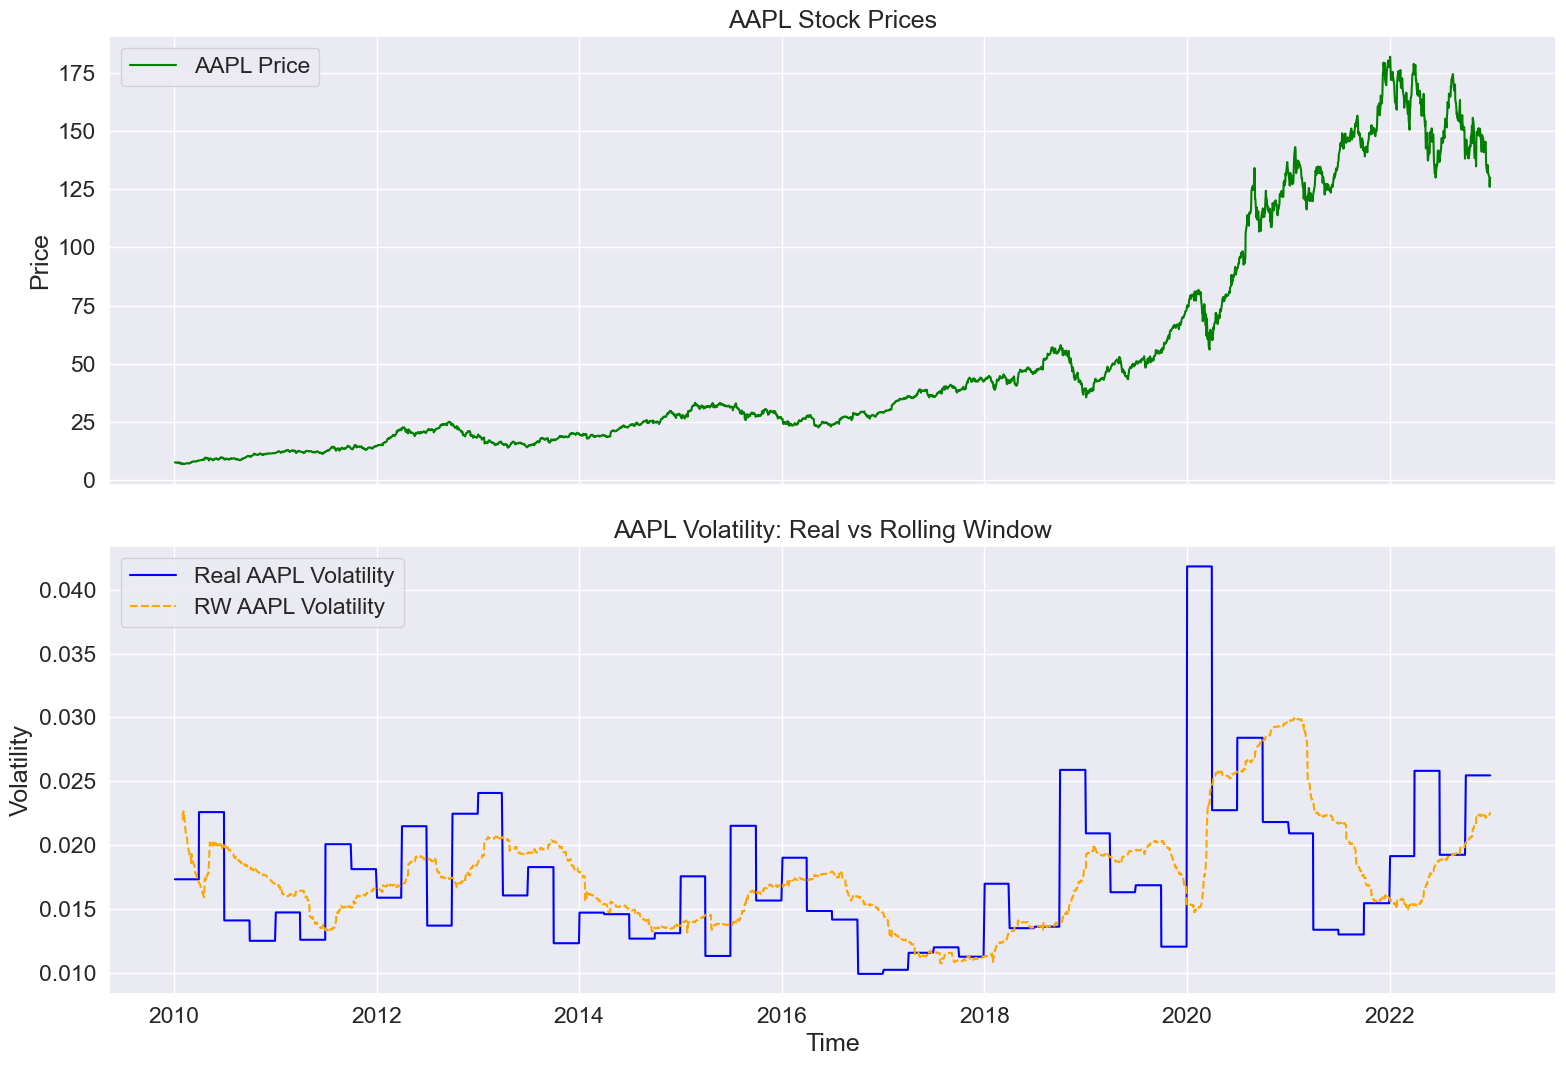

In [9]:
# PLOTTING PERFORMANCE SUMMARY OF THE ROLLING WINDOW PREDICTOR

# Call the function for AAPL
plot_prices_volatilities_for_rw(stocksPrices, df_volatility_aapl['AAPL Volatility'], df_rw_volatility_aapl['AAPL Volatility'], 'AAPL')

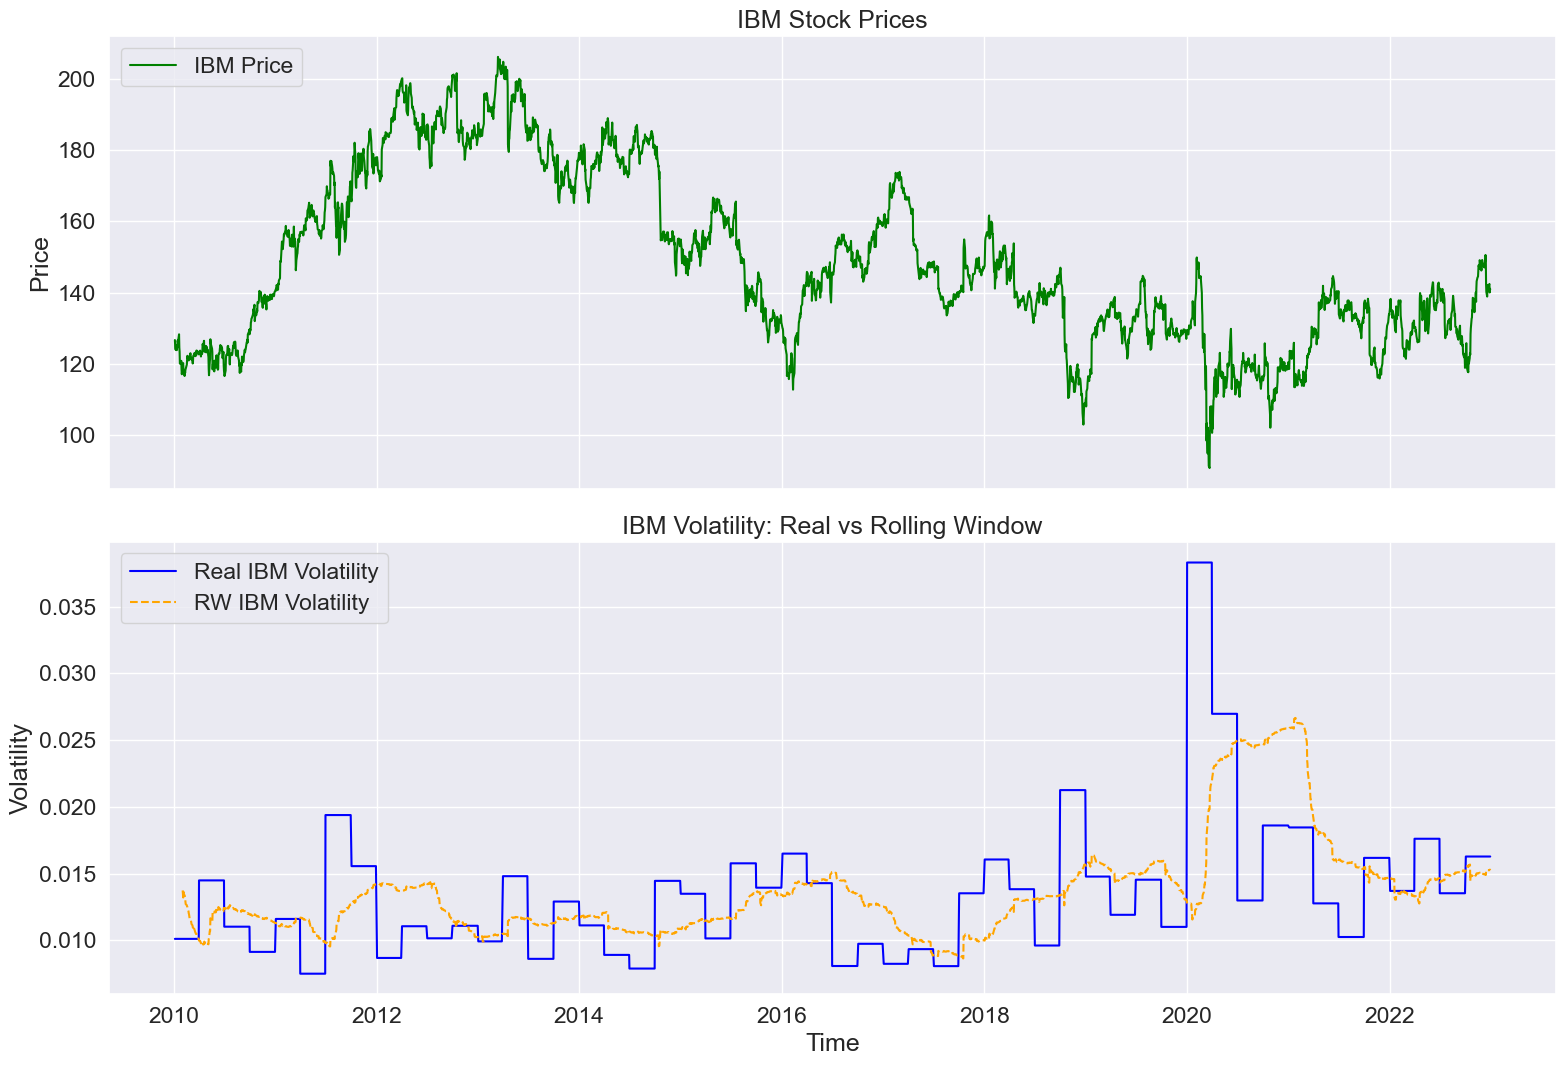

In [10]:
plot_prices_volatilities_for_rw(stocksPrices, df_volatility_ibm['IBM Volatility'], df_rw_volatility_ibm['IBM Volatility'], 'IBM')

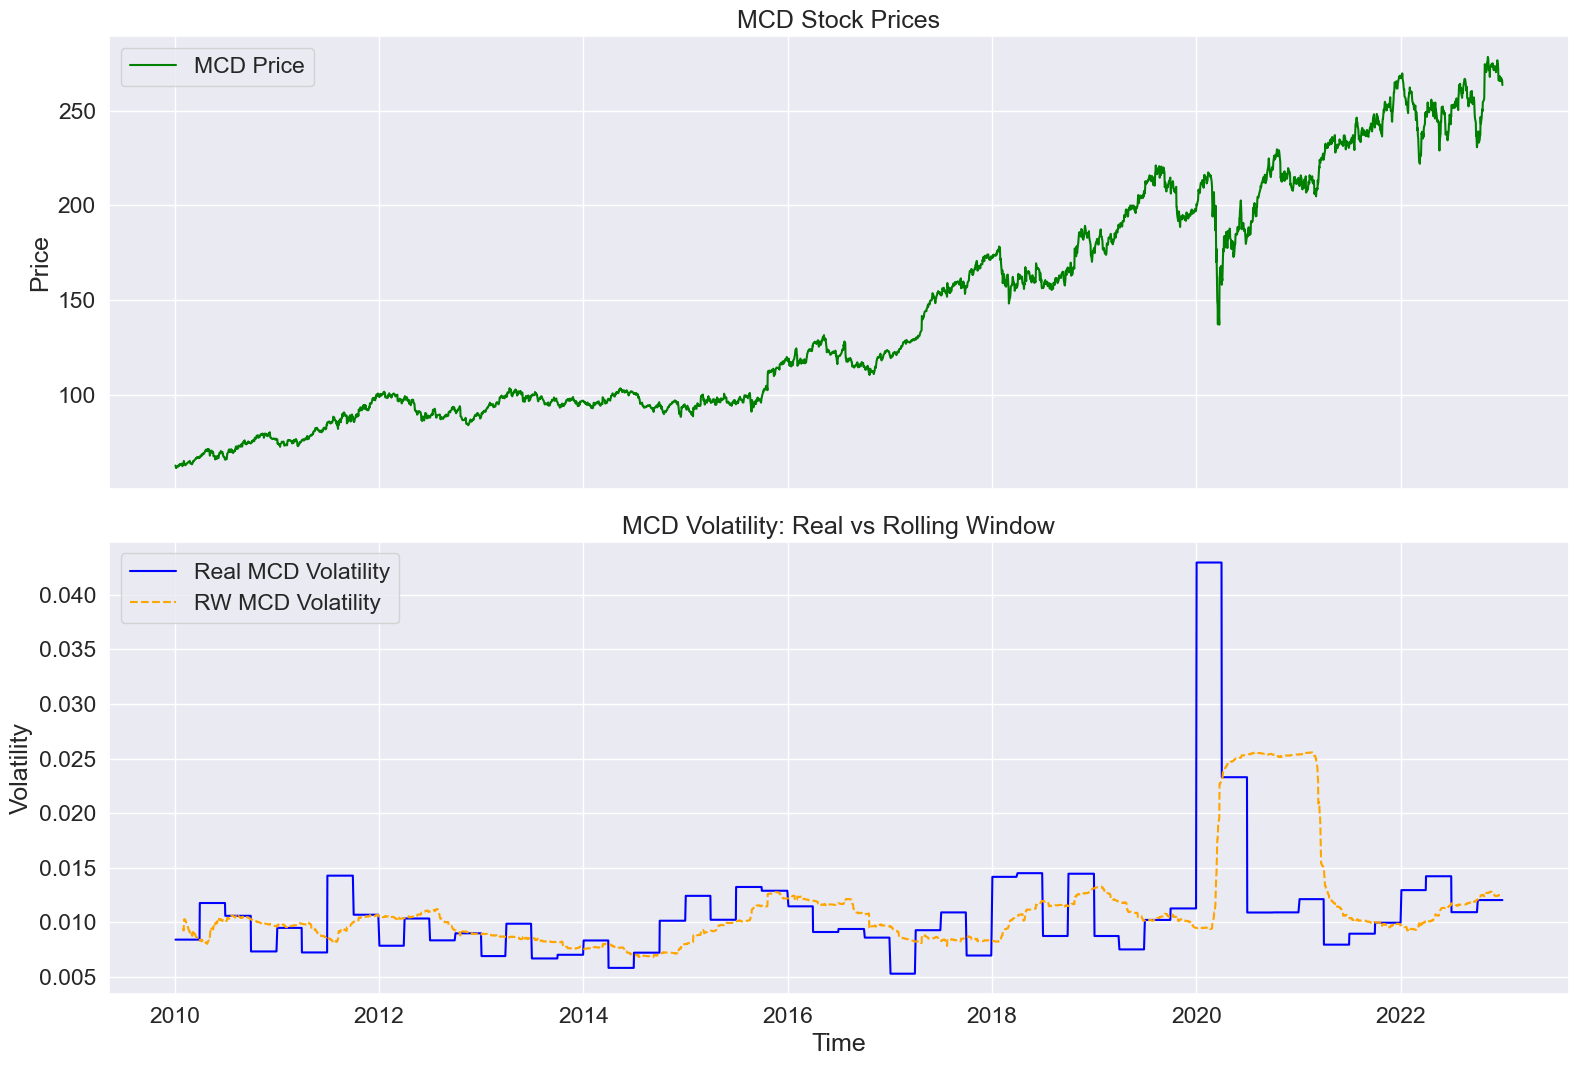

In [11]:
plot_prices_volatilities_for_rw(stocksPrices, df_volatility_mcd['MCD Volatility'], df_rw_volatility_mcd['MCD Volatility'], 'MCD')

decay factor used: 0.9944701686732144



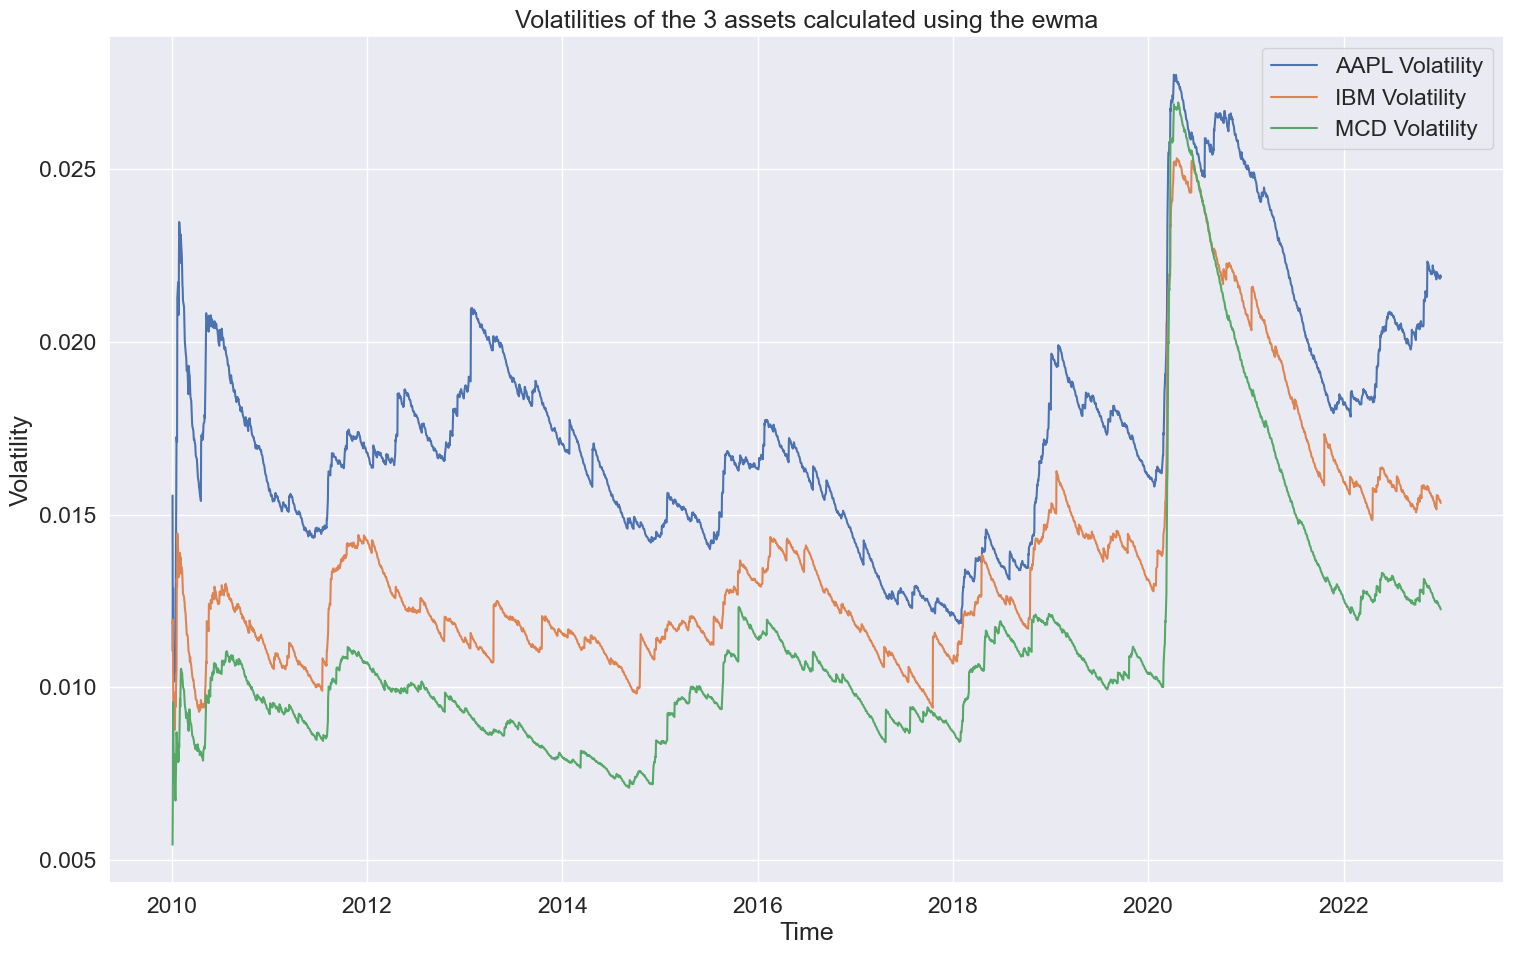

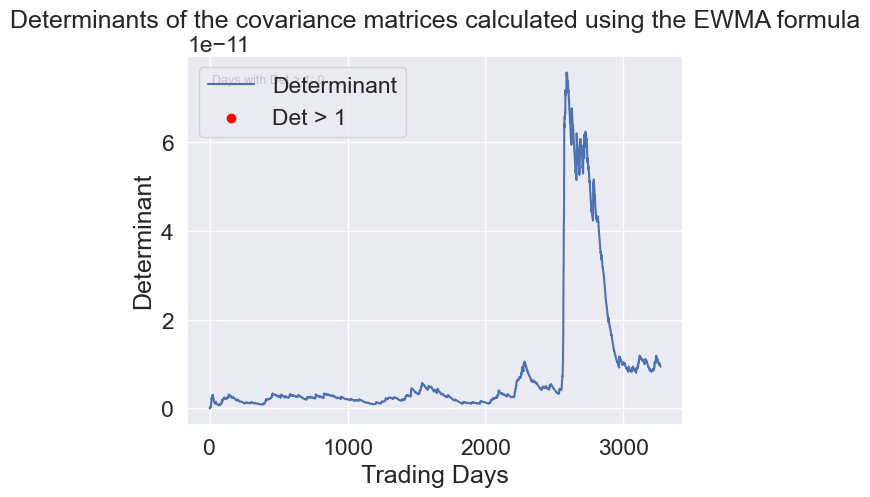

In [12]:
# EWMA

ewma_halflife = 125
# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula

beta = 2 ** (-1 / ewma_halflife)
print("decay factor used: " + str(beta) + "\n")

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
ewmaDict = dict(_ewma_cov(stocksPercentageChangeReturn, ewma_halflife))

ewma_volatilities = {}

for date, cov_matrix in ewmaDict.items():
    volatilities = np.sqrt(np.diag(cov_matrix.values))
    ewma_volatilities[date] = pd.DataFrame(data = volatilities, index = cov_matrix.index, columns = ["volatility"])

# now ewma_volatilities is a dictionary that contains the real volatilities of the 3 assets for every day with the same key of the ewmaDict dictionary(the timestamp)
    
# now separate the real volatilities of the 3 assets in 3 different dataframes
ewma_volatility_dict_aapl = {}
ewma_volatility_dict_ibm = {}
ewma_volatility_dict_mcd = {}

for date, volatilities in ewma_volatilities.items():
    ewma_volatility_dict_aapl[date] = volatilities.loc[7]["volatility"] # 7 is the PERMCO code of AAPL
    ewma_volatility_dict_ibm[date] = volatilities.loc[20990]["volatility"] # 20990 is the PERMCO code of IBM
    ewma_volatility_dict_mcd[date] = volatilities.loc[21177]["volatility"] # 21177 is the PERMCO code of MCD

# Convert the dictionaries to DataFrames for easier manipulation and plotting
df_ewma_volatility_aapl = pd.DataFrame(list(ewma_volatility_dict_aapl.items()), columns=['Date', 'AAPL Volatility'])
df_ewma_volatility_ibm = pd.DataFrame(list(ewma_volatility_dict_ibm.items()), columns=['Date', 'IBM Volatility'])
df_ewma_volatility_mcd = pd.DataFrame(list(ewma_volatility_dict_mcd.items()), columns=['Date', 'MCD Volatility'])

# Set the 'Date' column as the index
df_ewma_volatility_aapl.set_index('Date', inplace=True)
df_ewma_volatility_ibm.set_index('Date', inplace=True)
df_ewma_volatility_mcd.set_index('Date', inplace=True)

# Plot the real volatilities of the 3 assets
plt.figure(figsize=(18, 11))
plt.plot(df_ewma_volatility_aapl, label='AAPL Volatility')
plt.plot(df_ewma_volatility_ibm, label='IBM Volatility')
plt.plot(df_ewma_volatility_mcd, label='MCD Volatility')
plt.legend()
plt.title("Volatilities of the 3 assets calculated using the ewma")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()

# here i study the determinants of the covariance matrices calculated using the ewma formula
determinants_ewma = []
indices = []  # To store the indices for the x-axis
days_greater_than_one_indices = []  # To store indices where determinant > 1
days_greater_than_one_values = []  # To store determinant values where > 1

for index, (date, cov_matrix) in enumerate(ewmaDict.items()):
    determinant = np.linalg.det(cov_matrix)
    determinants_ewma.append(determinant)
    indices.append(index)
    if determinant > 1:
        days_greater_than_one_indices.append(index)
        days_greater_than_one_values.append(determinant)

# Plotting all determinants
plt.plot(indices, determinants_ewma, label='Determinant', zorder=1)

# Highlighting determinants > 1 with red dots
plt.scatter(days_greater_than_one_indices, days_greater_than_one_values, color='red', zorder=2, label='Det > 1')

# Adding a text annotation for the count of days with determinant > 1
plt.text(0.05, 0.95, f'Days with Det > 1: {len(days_greater_than_one_indices)}', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')

plt.title("Determinants of the covariance matrices calculated using the EWMA formula")
plt.xlabel("Trading Days")
plt.ylabel("Determinant")
plt.legend()
plt.show()

Next we import the precomputed MGARCH predictors (computed using the rmgarch
package in R). We used the first 250 days for training. Hence the first
predictors is given at day 250, and predicts the covariance matrix for day 251.
(Python uses zero-based indexing, so the first predictor will have time index 249.)

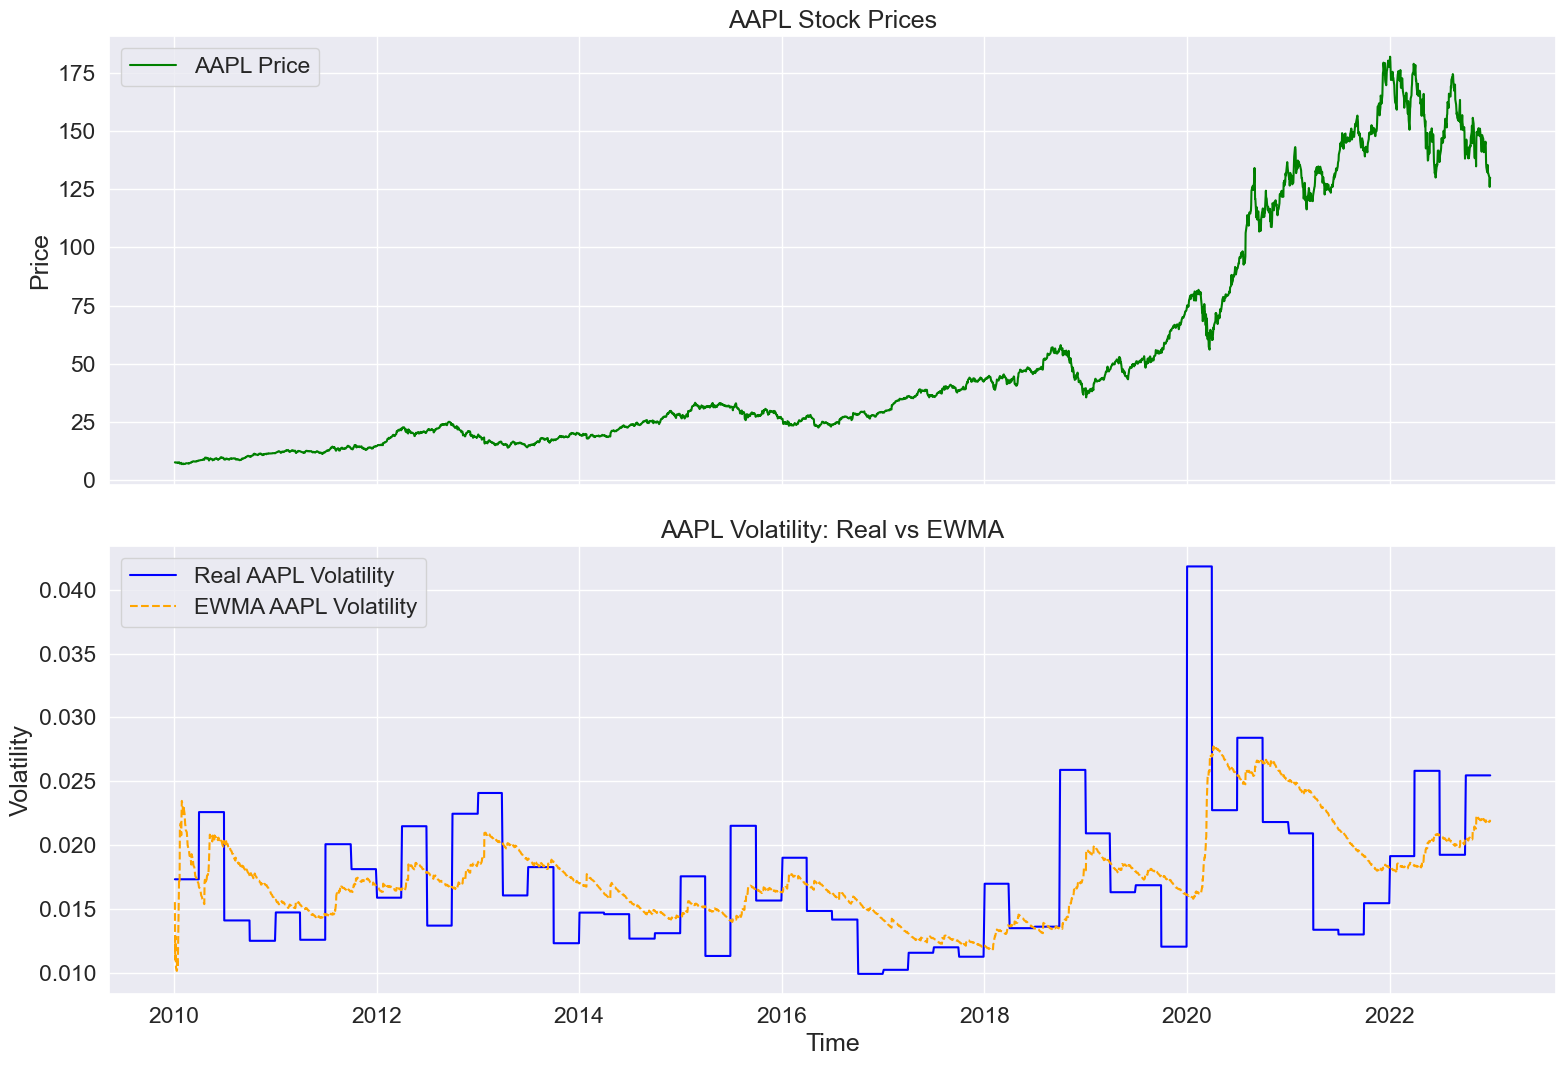

In [13]:
# summary of the performance of the ewma predictor
plot_prices_volatilities_for_ewma(stocksPrices, df_volatility_aapl['AAPL Volatility'], df_ewma_volatility_aapl['AAPL Volatility'], 'AAPL')

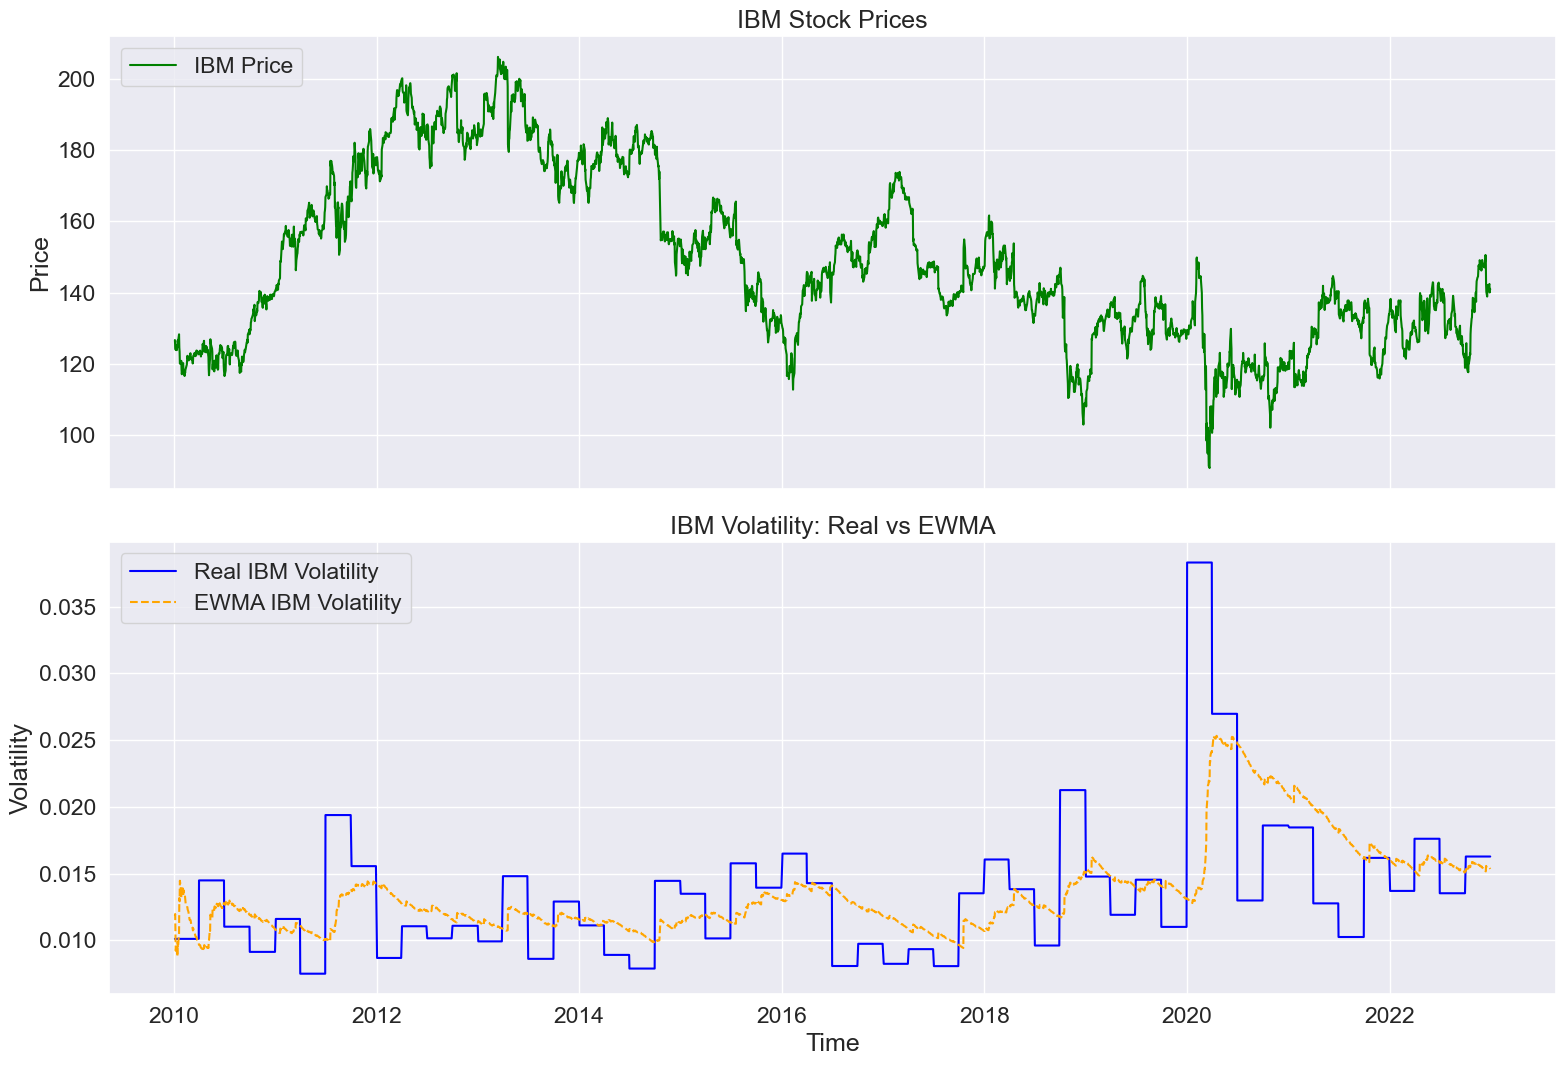

In [14]:
plot_prices_volatilities_for_ewma(stocksPrices, df_volatility_ibm['IBM Volatility'], df_ewma_volatility_ibm['IBM Volatility'], 'IBM')

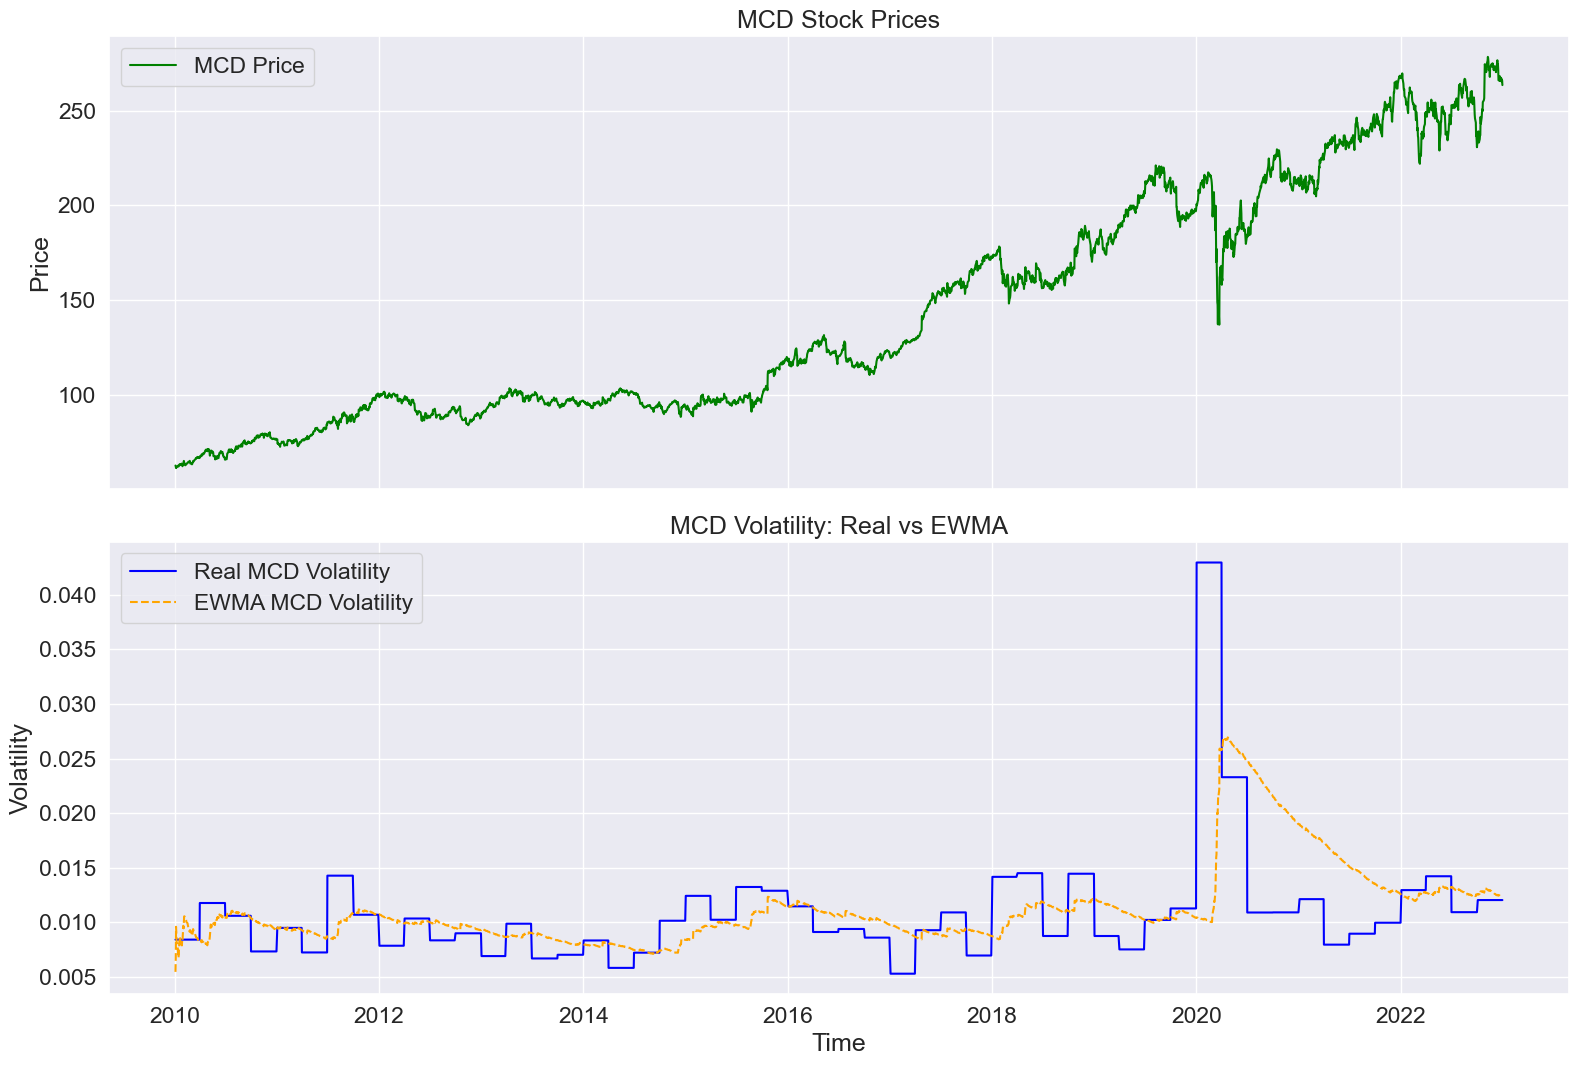

In [15]:
plot_prices_volatilities_for_ewma(stocksPrices, df_volatility_mcd['MCD Volatility'], df_ewma_volatility_mcd['MCD Volatility'], 'MCD')

In [16]:
'''
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/mgarch_stocks_adj.csv", index_col=None)

# here we are obtaining the covariance matrix calculated for every day from the csv file;
# so this covariance matrix estimation is done with real returns and not with interpolated returns
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio

# Remove first year since it was used for training
times = stocksPercentageChangeReturn.index[249:] 
mgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])} 

# LOG-LIKELIHOOD MGARCH
print("Computing MGARCH log-likelihood...\n")

returns_temp = stocksPercentageChangeReturn.loc[pd.Series(mgarchDict).index].values[1:]
times = pd.Series(mgarchDict).index[1:]
Sigmas_temp = np.stack([mgarchDict[t].values for t in mgarchDict.keys()])[:-1]
log_likelihood_mgarch = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

print("Computing MGARCH regret...\n")
# REGRET MGARCH
regret_mgarch = log_likelihood_prescient - log_likelihood_mgarch
'''

'\n# MGARCH precomputed in R due to computational complexity\n# The covariance matrices were computed for 100*r for numerical reasons \n\nmgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/mgarch_stocks_adj.csv", index_col=None)\n\n# here we are obtaining the covariance matrix calculated for every day from the csv file;\n# so this covariance matrix estimation is done with real returns and not with interpolated returns\nSigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, stocksPercentageChangeReturn.shape[1]) / 10000 # returns.shape[1] gives the number of columns in the returns DataFrame, which corresponds to the number of assets in the portfolio\n\n# Remove first year since it was used for training\ntimes = stocksPercentageChangeReturn.index[249:] \nmgarchDict = {times[t]: pd.DataFrame(Sigmas[t], index=stocksPercentageChangeReturn.columns, columns=stocksPercentageChangeReturn.columns) for t in range(Sigmas.shape[0])} \n\n# LOG-LIKELIHOOD MGARCH\nprint("Computing 

# Define end and start dates for backtests

In [17]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [18]:
names = ["RW", "EWMA", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [rwDict, ewmaDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# MSEs


RW MSE: 
mean: 0.000004
std: 0.000019
max: 0.000128

EWMA MSE: 
mean: 0.000004
std: 0.000019
max: 0.000126


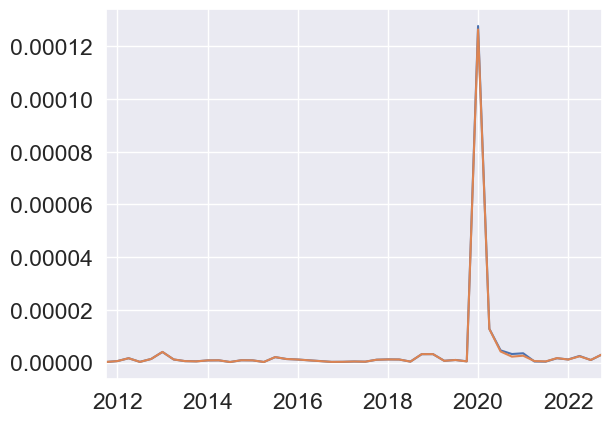

In [19]:
#TODO: UNIFY HERE ALL DICTIONARIES AND UNDESTAND HOW MSE IS CALCULATED
plt.figure()
for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        MSE_temp = MSE(stocksPercentageChangeReturn, predictorDict).resample("Q").mean()
        print("\n" + names[i] + " MSE: ")
        print(f"mean: {MSE_temp.mean():.6f}")
        print(f"std: {MSE_temp.std():.6f}")
        print(f"max: {MSE_temp.max():.6f}")
        MSE_temp.plot()

# Log likelihoods

In [20]:
'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

for i, predictorDict in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

Computing RW log-likelihood...
Computing EWMA log-likelihood...
Computing PRESCIENT log-likelihood...


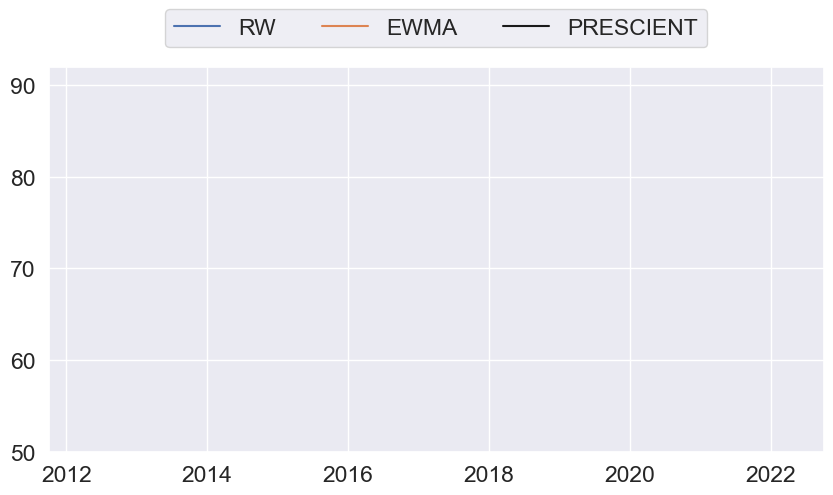

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(50,92);

# Regrets

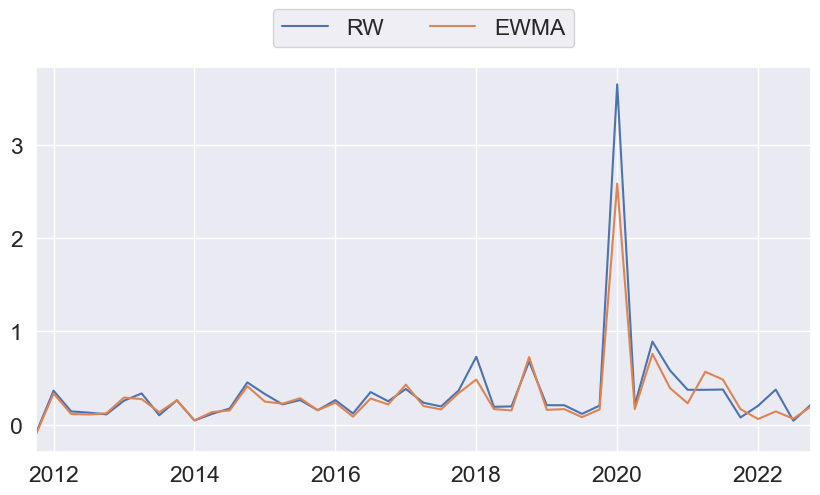

In [22]:
'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the regret value 
    (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''

for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]
    
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);


### Regret metrics

In [23]:
for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        print("\n" + name + " regret")
        print(f"mean: {metrics[0]:.2f}")
        print(f"std: {metrics [1]:.2f}")
        print(f"max: {metrics[2]:.2f}")


# do the same thing for log-likelihoods dictionary
for name in log_likelihoods:
    log_likelihood = log_likelihoods[name].resample("Q").mean()
    metrics = (np.mean(log_likelihood).round(1), np.std(log_likelihood).round(1), np.max(log_likelihood).round(1))

    print("\n" + name + " log-likelihood")
    print(f"mean: {metrics[0]:.2f}")
    print(f"std: {metrics [1]:.2f}")
    print(f"max: {metrics[2]:.2f}")


RW regret
mean: 0.30
std: 0.50
max: 3.70

EWMA regret
mean: 0.30
std: 0.40
max: 2.60

RW log-likelihood
mean: 8.70
std: 1.10
max: 10.10

EWMA log-likelihood
mean: 8.70
std: 1.00
max: 10.10

PRESCIENT log-likelihood
mean: 9.00
std: 0.70
max: 10.50


# Portfolio optimization

In [24]:
# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}
sigma_tar = 0.1
excess = True

### Equally weighted

In [25]:
# just creates the object for every trader; traders_eq_w is a dictionary that for every predictor name(key) has a value associated
# that is the memory address of the just created object

# this is a class initialization; so traders eq w is an instance of the class EqWeighted

'''
so the parameter of the class EqWeighted are:
returns: dataframe of returns taken from the csv file(in this case SP500_top25_adjusted.csv)
predictors: list of distionaries where each dictionary is a predictor -> RW,EWMA,IEWMA,MGARCH,CM-IEWMA,PRESCIENT ARE ALL DICTIONARIES
names: list of strings that contains the names of the predictors
start_date: start date of the backtest
end_date: end date of the backtest
'''
# after this assignment, traders_eq_w is a dictionary with keys being the names of the predictors and values being the trader instances
# and every trader instance contains returns(the one take from the csv file), covariance matrices and the weights WS(weights that must be assigned to every asset) for the eq_weighted portfolio strategy
# the weights are the portfolio weights: so equal weights are equeally distributed among the assets; minimum variance weights are the weights that minimize the variance of the portfolio; etc.
print("start_date: " + str(start_date) + " - " + str(type(start_date)))

traders_eq_w = EqWeighted(stocksPercentageChangeReturn, predictors, names, start_date, end_date).backtest()
# print("traders_eq_w: ", traders_eq_w) #traders_eq_w:  {'RW': <utils.trading_model.Trader object at 0x00000292178F8E10>, 'EWMA': <utils.trading_model.Trader object at 0x00000292014297D0>, 'IEWMA': <utils.trading_model.Trader object at 0x0000029217729E90>, 'MGARCH': <utils.trading_model.Trader object at 0x0000029217529950>, 'CM-IEWMA': <utils.trading_model.Trader object at 0x000002921792A110>, 'PRESCIENT': <utils.trading_model.Trader object at 0x0000029217911E10>}

# print the dimension of the dictionary
# print("traders_eq_w dimension: " + str(len(traders_eq_w))) -> is 6 as the predictor list dimension

# print everything about the first dictionary object
# print("traders_eq_w first object: " + str(traders_eq_w['RW'])) -> traders_eq_w first object: <utils.trading_model.Trader object at 0x000001E8F8AEA0D0>

start_date: 2011-12-28 00:00:00 - <class 'pandas._libs.tslibs.timestamps.Timestamp'>


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


In [26]:
create_table(traders_eq_w, sigma_tar, rf, excess) # inside this function all the metrics are calculated and printed



name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x0000018FB69920D0>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  0.9999999999999999


name:  EWMA
the trader object is:  <utils.trading_model.Trader object at 0x0000018FB7952B90>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0


name:  PRESCIENT
the trader object is:  <utils.trading_model.Trader object at 0x0000018FB7991250>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper
sum_w_t:  1.0
metrics before calling _create_table_helper function:  {'RW': metrics(mean_return=0.060110952210126085, risk=0.10673828204836451, sharpe=0.5631620732183887, drawdown=0.1956749303649379), 'EWMA': metrics(mean_return=0.05665067327233063, risk=0.10175317515946739, sharpe=0.556746000147394, drawdown=0.17974631056627

### Minimum risk

In [27]:
traders_min_risk = MinRisk(stocksPercentageChangeReturn, predictors, names, start_date, end_date).backtest(additonal_cons)
create_table(traders_min_risk, sigma_tar, rf, excess)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:37<00:00, 12.65s/it]




name:  RW
the trader object is:  <utils.trading_model.Trader object at 0x0000018FB796F690>
changing weights to achieve desired volatility, using sigma hat obtained from the covariance formula of the paper


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

### Maximum diversification 

In [ ]:
traders_max_diverse = MaxDiverse(stocksPercentageChangeReturn, predictors, names, start_date, end_date).backtest(additonal_cons)
create_table(traders_max_diverse, sigma_tar, rf, excess)

### Risk parity 

In [ ]:
traders_risk_par = RiskParity(stocksPercentageChangeReturn, predictors, names, start_date, end_date).backtest()
create_table(traders_risk_par, sigma_tar, rf, excess)

### Mean variance

In [ ]:
def tune_returns(returns):
    """
    Cuts element in each row at its 40th and 60th percentile
    up and down
    """
    
    returns_tuned = np.zeros_like(returns)

    for t in range(returns.shape[0]):
        r_temp = returns.iloc[t]
        returns_tuned[t] = np.clip(r_temp, a_min=r_temp.quantile(0.4), a_max=r_temp.quantile(0.6))

    return pd.DataFrame(returns_tuned, index=returns.index, columns=returns.columns)

In [ ]:
r_hat_ewma = pd.DataFrame(dict(_ewma_mean(stocksPercentageChangeReturn, halflife=250))).T
r_hat_ewma = tune_returns(r_hat_ewma)

mean_predictors = [r_hat_ewma for name in names]

traders_mean_var = MeanVariance(stocksPercentageChangeReturn, predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date= end_date).backtest(additonal_cons, sigma_tar, rhos=None)
create_table(traders_mean_var, None, rf, excess, prescient=True)

In [ ]:
trader = traders_mean_var["CM-IEWMA"]
trader.returns = trader.R
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 63 day halfife
trader = traders_mean_var["No clip"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 63 day halfife
trader = traders_mean_var["clip"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 63 day half-life
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 250 day halfife
trader = traders_mean_var["No clip"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250 day halfife
trader = traders_mean_var["clip"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250 day half-life
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 250 day half-life clip at 70th and 30th percentile
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
create_table(traders_mean_var, None, rf, excess)